### Importing Packages and API Key

In [15]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
from scipy import stats

# Load environment variables from the .env file
load_dotenv('../config.env')


True

In [16]:
# Import MlFinLab package
import mlfinlab
from mlfinlab.data_structures.standard_data_structures import (get_dollar_bars,
                                                               get_tick_bars, get_volume_bars)

from mlfinlab.multi_product.etf_trick import get_futures_roll_series

### Importing Data

In [17]:
# import ES_Trades data
#path = 'Data/ES_Trades.csv'
path = 'https://raw.githubusercontent.com/jjakimoto/finance_ml/refs/heads/master/datasets/Google.csv'

data = pd.read_csv(path)

# viewing data
data.head()


,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
1,2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2,2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
3,2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
4,2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


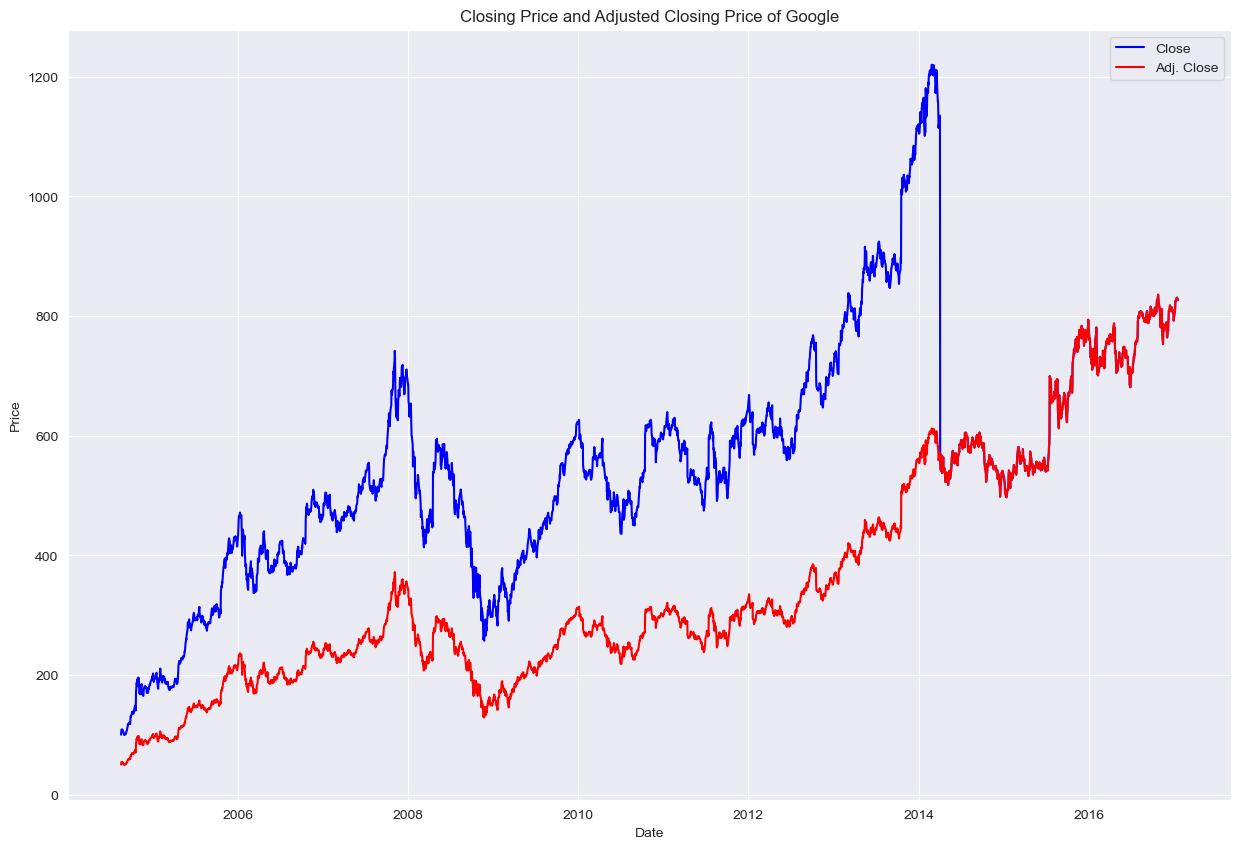

In [18]:
# plotting the closing price of the data and the adjusted closing price of the data (Adj. Close) on the same plot

# Ensure the date column is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Plotting the closing price and adjusted closing price
plt.figure(figsize=(15, 10))
plt.plot(data['Date'], data['Close'], label='Close', color='blue')
plt.plot(data['Date'], data['Adj. Close'], label='Adj. Close', color='red')
plt.title('Closing Price and Adjusted Closing Price of Google')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### Creating a Continuous Futures Contract using the ETF Trick

In [19]:
# producing a dataframe to count the number of bars in the data for each week

# Ensure the date column is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Create a week column
data['week'] = data['Date'].dt.isocalendar().week

# Count the number of bars in the data for each week
bar_count = data.groupby('week').count()

# Display the bar count
bar_count.head()



,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
week,,,,,,,,,,,,,
1,55,55,55,55,55,55,55,55,55,55,55,55,55
2,65,65,65,65,65,65,65,65,65,65,65,65,65
3,54,54,54,54,54,54,54,54,54,54,54,54,54
4,55,55,55,55,55,55,55,55,55,55,55,55,55
5,60,60,60,60,60,60,60,60,60,60,60,60,60


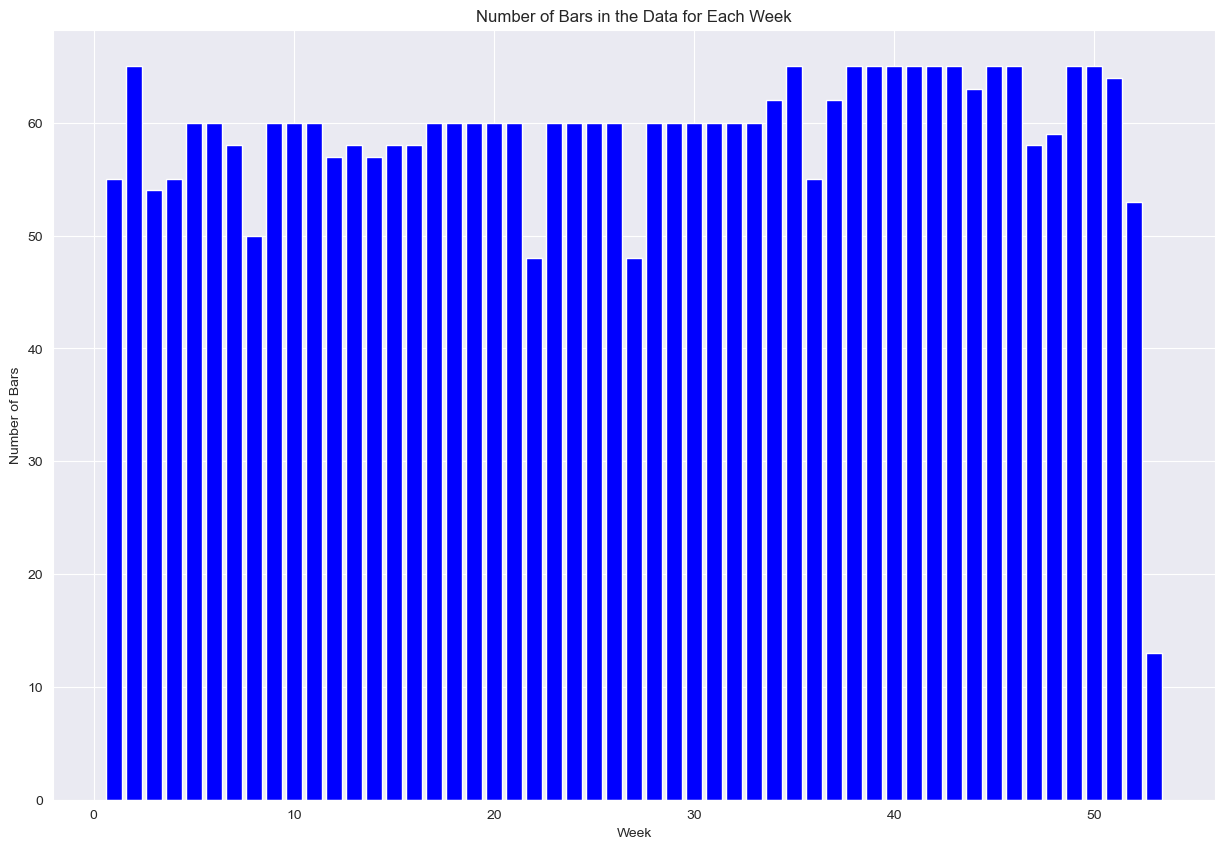

In [20]:
# plotining the number of bars in the data for each week

# Plotting the number of bars in the data for each week as a bar plot
plt.figure(figsize=(15, 10))
plt.bar(bar_count.index, bar_count['Date'], color='blue')
plt.title('Number of Bars in the Data for Each Week')
plt.xlabel('Week')
plt.ylabel('Number of Bars')
plt.show()


### Calculating Statisticl Propeties of Returns (Serial Correlation, Variance, Jarque-Bera Normality Test)

#### Serial Correlation

In [21]:
# adding a returns column to the data as a pct_change of the adjusted closing price

# Ensure the adjusted closing price column is clean
data['Adj. Close'].dropna(inplace=True)

# Compute the returns
data['returns'] = data['Adj. Close'].pct_change()

# Display the head of the data
data.head()


,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume,week,returns
0,2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0,34,NaN
1,2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0,34,0.079484
2,2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0,35,0.010064
3,2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0,35,-0.041408
4,2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0,35,0.010775


In [22]:
# calculating the serial correlation of returns for the data
# for dollar
data_serial_corr = data['returns'].autocorr()



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [23]:
# Testing which of the continuous contracts have the lowest serial correlation of returns
print('Dollar Serial Correlation:', data_serial_corr)



Dollar Serial Correlation: 0.010650541160256861


#### Variance

In [24]:
# Partioning each of the continuous contracts into monthly partitions by adding a months column to data set

# Ensure the date column is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Create a month column
data['month'] = data['Date'].dt.month

# computing the variance of returns for each monthly partition of data

# Ensure the returns column is clean
data['returns'].dropna(inplace=True)

# Compute the variance of returns for each monthly partition of data
data_variance = data.groupby('month')['returns'].var()

# calculate the variance of the variance of returns for the above partitions

# Ensure the variance column is clean
data_variance.dropna(inplace=True)

# Compute the variance of the variance of returns for the above partitions
data_variance_variances = data_variance.var()


In [25]:
# printing the variance of the variance of returns for each continuous contract
print('Data Variance of Variance:', data_variance_variances)


Data Variance of Variance: 2.573934805234021e-08


#### Jarque-Bera Normality Test

In [30]:
# applying the Jarque-Bera Normality Test to the returns of the data

# Check for missing values and remove them
data = data[np.isfinite(data['returns'])]

# Check for infinite values and remove them
data = data[np.isfinite(data['returns'])]

# Ensure there are enough data points
if len(data['returns']) > 2:
    data_jarque_bera = stats.jarque_bera(data['returns'])
else:
    data_jarque_bera = (np.nan, np.nan)


In [31]:
# Print the results
print('Data Jarque-Bera:', data_jarque_bera)


Data Jarque-Bera: SignificanceResult(statistic=17477.364608359025, pvalue=0.0)


### Plotting the Distributions of Returns

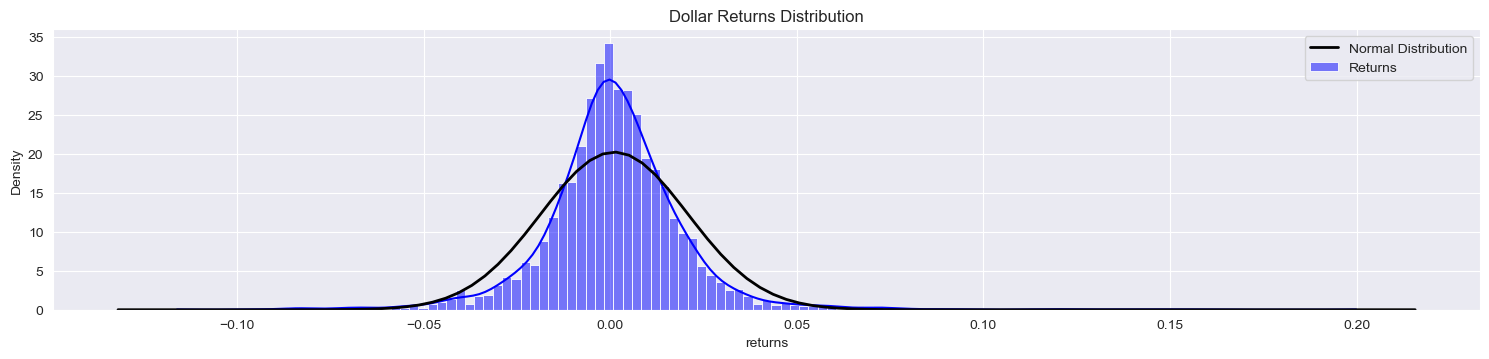

In [32]:

# Ensure the returns columns are clean
data['returns'].dropna(inplace=True)

# Plotting the distributions
plt.figure(figsize=(15, 10))

# Data returns distribution
plt.subplot(3, 1, 1)
sns.histplot(data['returns'], kde=True, stat="density", label='Returns', color='blue')
mean, std = stats.norm.fit(data['returns'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')
plt.title('Dollar Returns Distribution')
plt.legend()



plt.tight_layout()
plt.show()